# VGG16 Model for Plant Disease Classification

This notebook implements a VGG16-based model for plant disease classification with a single output.

In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

## 1. Data Preparation

In [2]:
train_path = "../data/train"
valid_path = "../data/valid"
test_path = "test"


In [3]:
# Load training data
file_train = []
label_train = []
folds = os.listdir(train_path)

for fold in folds:
    fold_path = os.path.join(train_path, fold)
    files = os.listdir(fold_path)
    for file in tqdm(files):
        img_path = os.path.join(fold_path, file)
        file_train.append(img_path)
        label_train.append(fold)

100%|██████████| 1961/1961 [00:00<00:00, 326441.90it/s]


In [4]:
# Load validation data
file_valid = []
label_valid = []
folds = os.listdir(valid_path)

for fold in folds:
    fold_path = os.path.join(valid_path, fold)
    files = os.listdir(fold_path)
    for file in tqdm(files):
        img_path = os.path.join(fold_path, file)
        file_valid.append(img_path)
        label_valid.append(fold)

100%|██████████| 490/490 [00:00<00:00, 489335.47it/s]


In [ ]:
# Create DF
df_train = pd.DataFrame({
    'filename': file_train,
    'label': label_train
})

df_valid = pd.DataFrame({
    'filename': file_valid,
    'label': label_valid
})

In [ ]:
#display class distribution
print("Training class distribution:")
print(df_train['label'].value_counts())
print("\nValidation class distribution:")
print(df_valid['label'].value_counts())

#Number of classes
num_classes = len(df_train['label'].unique())
print(f"\nNumber of classes: {num_classes}")

Training class distribution:
label
Soybean___healthy                                     2022
Apple___Apple_scab                                    2016
Orange___Haunglongbing_(Citrus_greening)              2010
Apple___healthy                                       2008
Pepper,_bell___healthy                                1988
Apple___Black_rot                                     1987
Tomato___Tomato_Yellow_Leaf_Curl_Virus                1961
Potato___Late_blight                                  1939
Potato___Early_blight                                 1939
Tomato___healthy                                      1926
Grape___Esca_(Black_Measles)                          1920
Tomato___Early_blight                                 1920
Pepper,_bell___Bacterial_spot                         1913
Corn_(maize)___Northern_Leaf_Blight                   1908
Corn_(maize)___Common_rust_                           1907
Grape___Black_rot                                     1888
Tomato___Leaf_Mold   

## 2. Data Augmentation 

In [ ]:
#data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

img_size = (224, 224)  
batch_size = 32

In [8]:
train_gen = train_datagen.flow_from_dataframe(
    df_train,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

valid_gen = valid_datagen.flow_from_dataframe(
    df_valid,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 70295 validated image filenames belonging to 38 classes.
Found 17572 validated image filenames belonging to 38 classes.


## 3. VGG16 Model 

In [ ]:
from tensorflow.keras.optimizers import AdamW

#AdamW to handle weigh decay (better regularization) -> prevent overfitting
optimizer = AdamW(
    learning_rate=3e-5,      
    weight_decay=1e-4,       
    global_clipnorm=1.0,     
    beta_1=0.9,              
    beta_2=0.999             
)

In [ ]:
def create_vgg16_model(num_classes, trainable_layers=0):

   
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    
    for layer in base_model.layers:
        layer.trainable = False
    
    #unfreeze the specified number of layers from the end
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
   
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        
        #first fully connected block
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        #second dense block
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

In [12]:

vgg_model = create_vgg16_model(num_classes=num_classes, trainable_layers=0)


vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

## 4. Training with Progressive Fine-tuning

In [11]:

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'vgg16_model_{epoch:02d}_{val_accuracy:.4f}.keras'),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [12]:
# Calculate steps
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_valid) // batch_size

## Progressive Fine Tuning

In [15]:


# Train the model
history_stage1 = vgg_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
2196/2196 [==============================] - ETA: 0s - loss: 1.8836 - accuracy: 0.4920 - precision: 0.7727 - recall: 0.3362
Epoch 1: val_accuracy improved from -inf to 0.78939, saving model to ./checkpoints\vgg16_model_01_0.7894.keras
2196/2196 [==============================] - 5116s 2s/step - loss: 1.8836 - accuracy: 0.4920 - precision: 0.7727 - recall: 0.3362 - val_loss: 0.7027 - val_accuracy: 0.7894 - val_precision: 0.8853 - val_recall: 0.6974 - lr: 3.0000e-05
Epoch 2/5
2196/2196 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.7675 - precision: 0.8645 - recall: 0.6795
Epoch 2: val_accuracy improved from 0.78939 to 0.85422, saving model to ./checkpoints\vgg16_model_02_0.8542.keras
2196/2196 [==============================] - 5133s 2s/step - loss: 0.7691 - accuracy: 0.7675 - precision: 0.8645 - recall: 0.6795 - val_loss: 0.4623 - val_accuracy: 0.8542 - val_precision: 0.9024 - val_recall: 0.8124 - lr: 3.0000e-05
Epoch 3/5
2196/2196 [==================

In [16]:
vgg_model.save("Vgg_Plant_Disease.h5")

In [14]:
from tensorflow.keras.models import load_model
vgg_model = load_model("Vgg_Plant_Disease.h5")

In [16]:

fine_tuned_model = create_vgg16_model(num_classes=num_classes, trainable_layers=8)


fine_tuned_model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)




In [17]:
history_stage2 = fine_tuned_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
2196/2196 [==============================] - ETA: 0s - loss: 1.6671 - accuracy: 0.5581 - precision: 0.8410 - recall: 0.3987
Epoch 1: val_accuracy improved from -inf to 0.90073, saving model to ./checkpoints\vgg16_model_01_0.9007.keras
2196/2196 [==============================] - 12074s 5s/step - loss: 1.6671 - accuracy: 0.5581 - precision: 0.8410 - recall: 0.3987 - val_loss: 0.3334 - val_accuracy: 0.9007 - val_precision: 0.9373 - val_recall: 0.8680 - lr: 1.0000e-05
Epoch 2/5
2196/2196 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.9013 - precision: 0.9460 - recall: 0.8469
Epoch 2: val_accuracy improved from 0.90073 to 0.95708, saving model to ./checkpoints\vgg16_model_02_0.9571.keras
2196/2196 [==============================] - 9211s 4s/step - loss: 0.3592 - accuracy: 0.9013 - precision: 0.9460 - recall: 0.8469 - val_loss: 0.1438 - val_accuracy: 0.9571 - val_precision: 0.9709 - val_recall: 0.9439 - lr: 1.0000e-05
Epoch 3/5
2196/2196 [=================

In [18]:
fine_tuned_model.save("vgg16_finetuned.h5")

In [31]:

evaluation = fine_tuned_model.evaluate(valid_gen, steps=validation_steps)
print(f"validation Loss: {evaluation[0]:.2f}")
print(f"validation Accuracy: {evaluation[1]:.2f}")


549/549 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9512 - loss: 0.1653 - precision: 0.9631 - recall: 0.9393
validation Loss: 0.13
validation Accuracy: 0.96


In [32]:
#predictions
y_true = valid_gen.classes
y_pred_prob = fine_tuned_model.predict(valid_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

#class names
class_names = list(valid_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)



550/550 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step


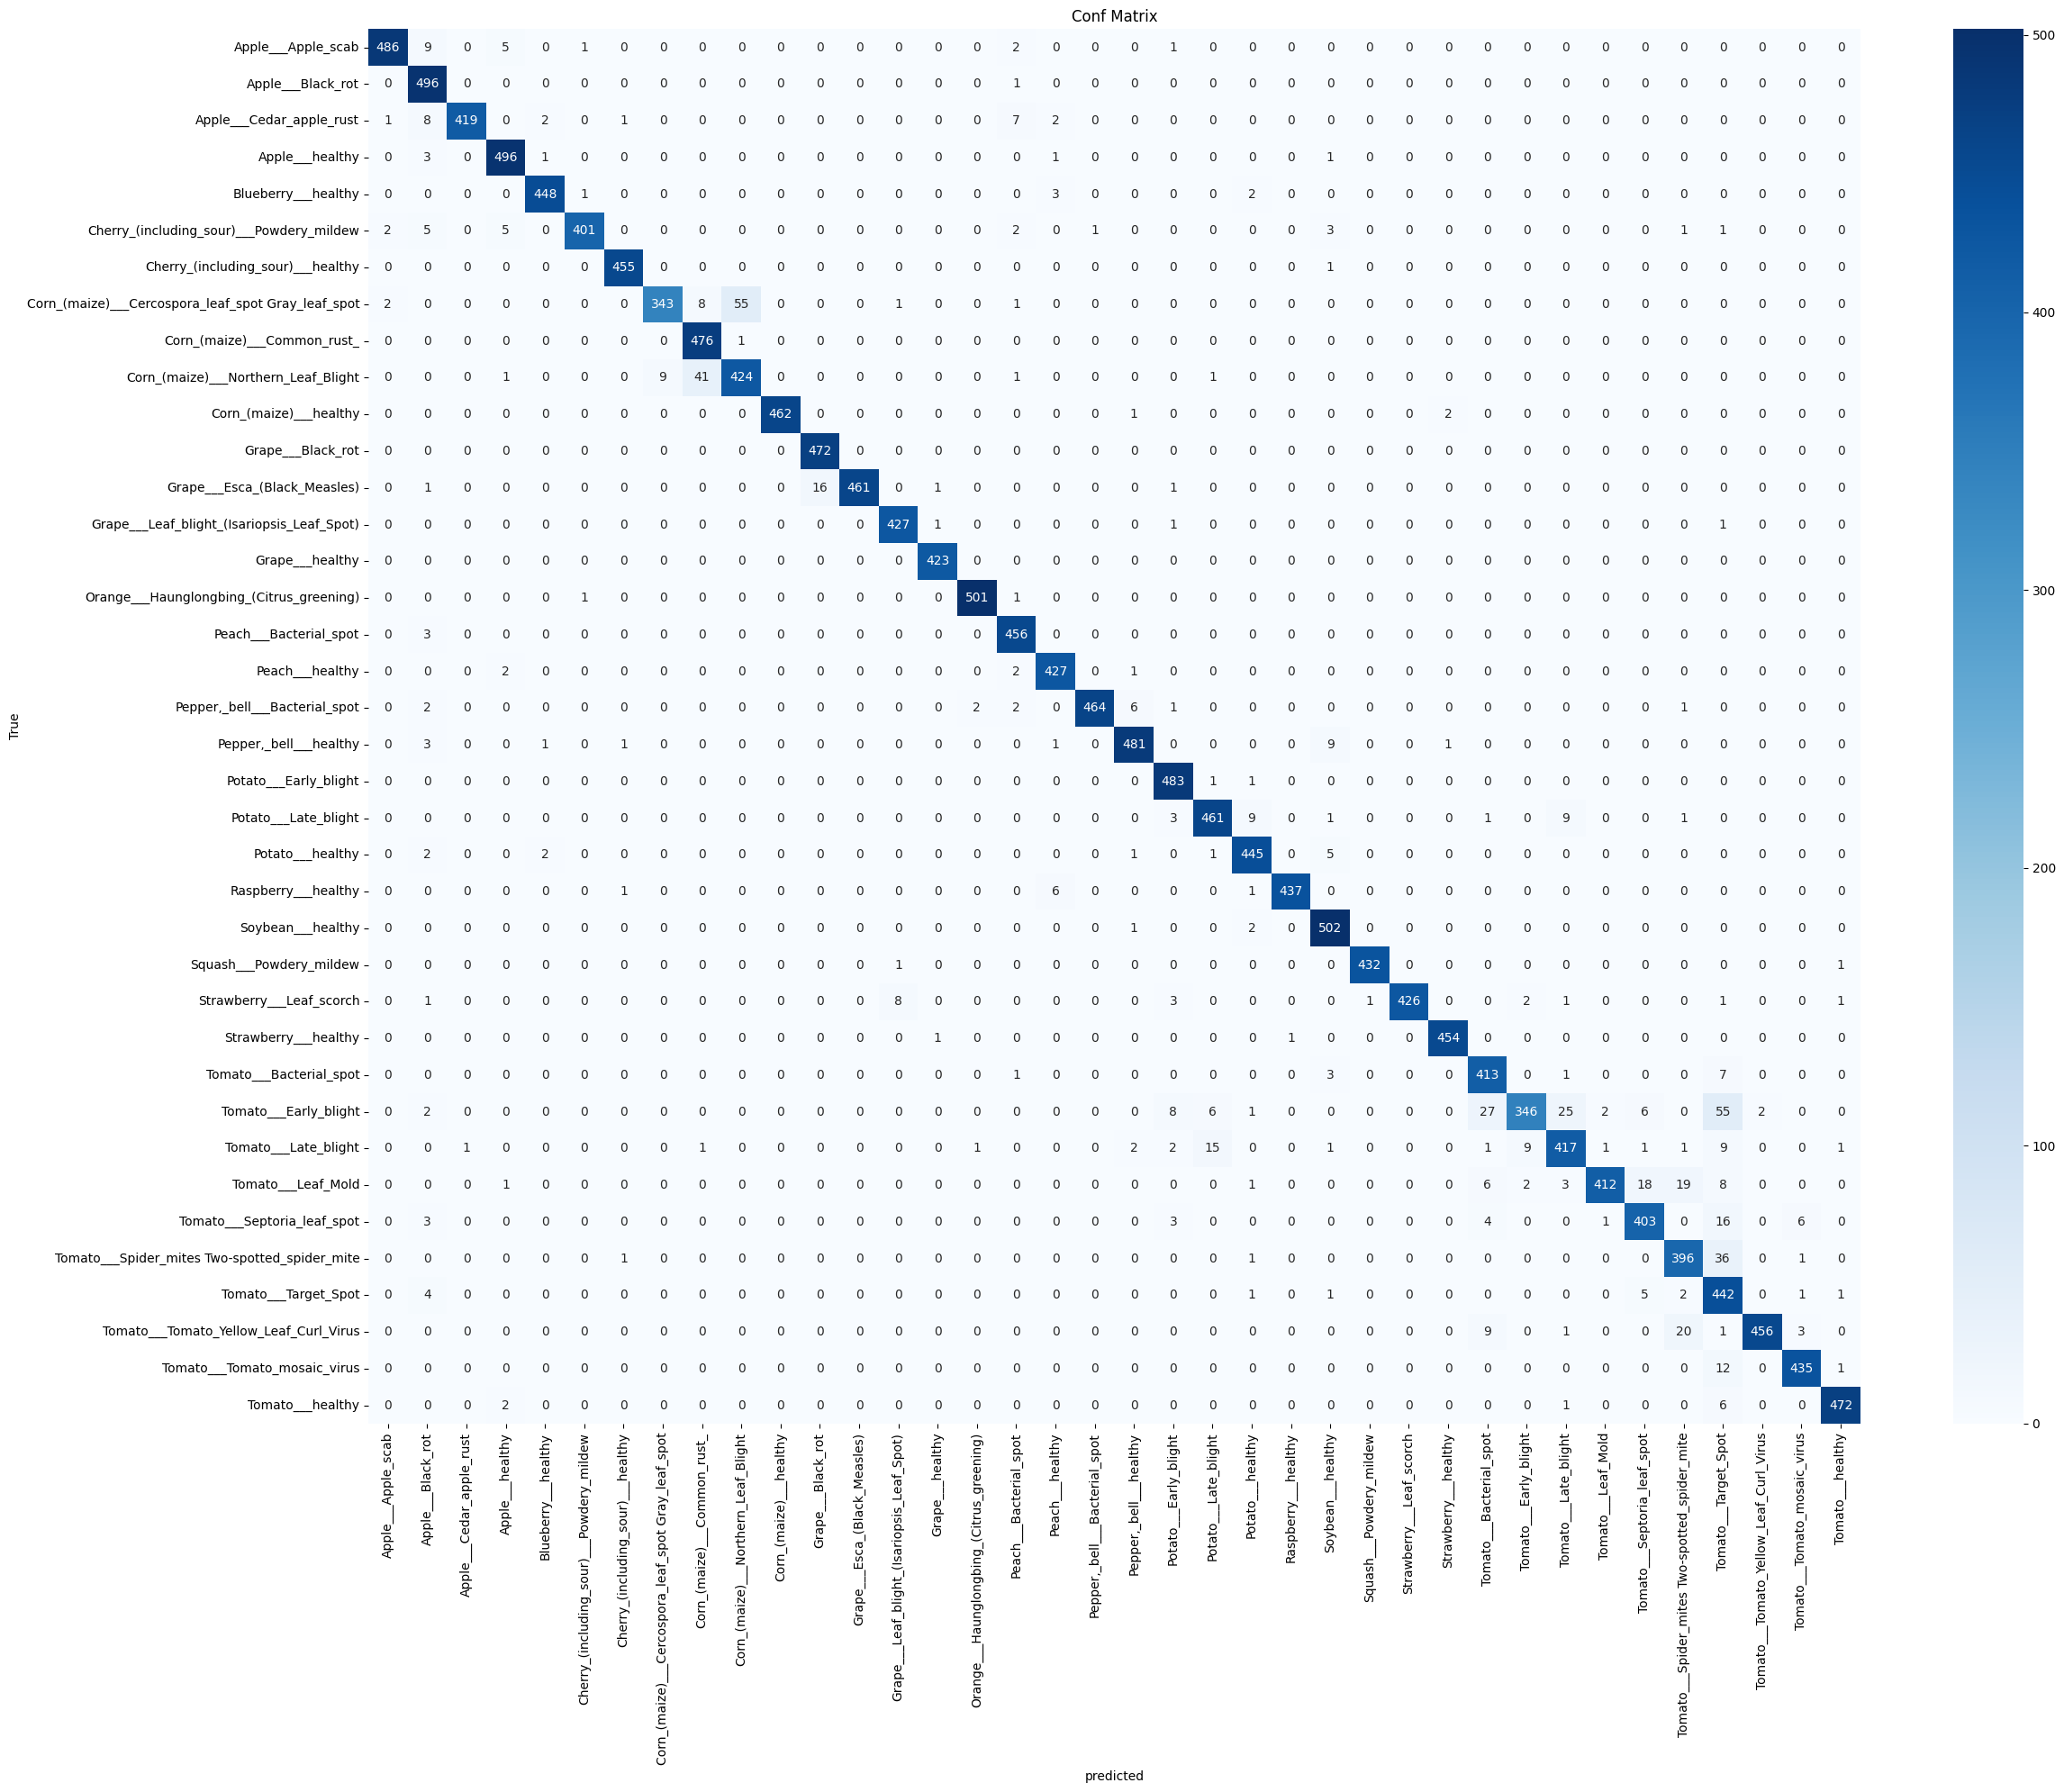

In [33]:
#confusion matrix
plt.figure(figsize=(25, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.title('Conf Matrix')
plt.tight_layout()
plt.show()

In [35]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.96      0.98       504
                                 Apple___Black_rot       0.92      1.00      0.95       497
                          Apple___Cedar_apple_rust       1.00      0.95      0.97       440
                                   Apple___healthy       0.97      0.99      0.98       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.95      0.97       421
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.84      0.90       410
                       Corn_(maize)___Common_rust_       0.90      1.00      0.95       477
               Corn_(maize)___Northern_Leaf_Blight       0.88      0.89      0.

In [53]:
def extract_plant_name(label):
    parts = label.split('_')
    return parts[0]

df_valid['plant'] = df_valid['label'].apply(extract_plant_name)

plant_counts = df_valid['plant'].value_counts()



In [54]:
plant_counts

plant
Tomato        4585
Apple         1943
Corn          1829
Grape         1805
Potato        1426
Pepper,        975
Strawberry     900
Peach          891
Cherry         877
Soybean        505
Orange         503
Blueberry      454
Raspberry      445
Squash         434
Name: count, dtype: int64

In [ ]:

unique_plants = df_valid['plant'].unique()
print(f"Found {len(unique_plants)} unique plants")

Found 14 unique plants


## Save the Model

In [37]:
fine_tuned_model.save("vgg16_plant_disease_model.h5")


## Conclusion

how to use a VGG16 model for plant disease classification with a single output.The model is trained using a progressive fine tuning approach:

1. First, we train only the top layers while keeping the VGG16 base frozen
2. Then, we fine-tune the last few convolutional layers with a lower learning rate

This approach helps prevent catastrophic forgetting and allows the model to better adapt to the specific plant disease classification task. The model achieves good performance on the validation set and can be used for predicting plant diseases from new images.